In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Reading Data

Implementing Labelling algorithm 

In [2]:
#labelling algorithm X is price and w is our threshould
def labeling(X,w):
    n = len(X)
    y = np.array([0 for i in range(n)])
    FP=X[0]
    xh = X[0]
    xl = X[0]
    HT = 0
    LT = 0
    cid = 0
    FP_N = 0
    for i in range(n):
        if(X[i] > FP + X[0]*w):
            xh,HT,FP_N,cid  = X[i],i,i,1
            break
        if(X[i] < FP - X[0]*w):
            xh,HT,FP_N,cid  = X[i],i,i,-1
            break
    for i in range(FP_N+1,n):
        if(cid > 0):
            if(X[i]>xh):
                xh,HT = X[i],i
            if(X[i] < xh - xh*w and LT<= HT ):
                for j in range(n):
                    if(j>LT and j<=HT):
                        y[j] = 1
                xl,LT,cid = X[i],i,-1
        if(cid < 0):
            if(X[i]<xl):
                xl,LT = X[i],i
            if(X[i] > xl + xl*w and HT<= LT ):
                for j in range(n):
                    if(j>HT and j<=LT):
                        y[j] = -1
                xh,HT,cid = X[i],i,1
    return y

labelling data

normalize Data 
\begin{align*}
        f_{ij} & = \frac{x_{ij} - M^{\lambda}_{i}}{M^{\lambda}_{i}} ,x_{ij} \in X\\
        M^{\lambda}_{s}& = \frac{\sum_{i=s}^{s+ \lambda -1} x_i}{\lambda} , x_i \in x
    \end{align*}

In [3]:
import itertools as itt
import numbers
import numpy as np
import pandas as pd

from abc import abstractmethod
from typing import Iterable, Tuple, List


class BaseTimeSeriesCrossValidator:
    """
    Abstract class for time series cross-validation.
    Time series cross-validation requires each sample has a prediction time pred_time, at which the features are used to
    predict the response, and an evaluation time eval_time, at which the response is known and the error can be
    computed. Importantly, it means that unlike in standard sklearn cross-validation, the samples X, response y,
    pred_times and eval_times must all be pandas dataframe/series having the same index. It is also assumed that the
    samples are time-ordered with respect to the prediction time (i.e. pred_times is non-decreasing).
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    """
    def __init__(self, n_splits=10):
        if not isinstance(n_splits, numbers.Integral):
            raise ValueError(f"The number of folds must be of Integral type. {n_splits} of type {type(n_splits)}"
                             f" was passed.")
        n_splits = int(n_splits)
        if n_splits <= 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting n_splits = 2 "
                             f"or more, got n_splits = {n_splits}.")
        self.n_splits = n_splits
        self.pred_times = None
        self.eval_times = None
        self.indices = None

    @abstractmethod
    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, pd.Series):
            raise ValueError('X should be a pandas DataFrame/Series.')
        if not isinstance(y, pd.Series) and y is not None:
            raise ValueError('y should be a pandas Series.')
        if not isinstance(pred_times, pd.Series):
            raise ValueError('pred_times should be a pandas Series.')
        if not isinstance(eval_times, pd.Series):
            raise ValueError('eval_times should be a pandas Series.')
        if y is not None and (X.index == y.index).sum() != len(y):
            raise ValueError('X and y must have the same index')
        if (X.index == pred_times.index).sum() != len(pred_times):
            raise ValueError('X and pred_times must have the same index')
        if (X.index == eval_times.index).sum() != len(eval_times):
            raise ValueError('X and eval_times must have the same index')

        self.pred_times = pred_times
        self.eval_times = eval_times
        self.indices = np.arange(X.shape[0])


class PurgedWalkForwardCV(BaseTimeSeriesCrossValidator):
  """
  Purged walk-forward cross-validation
  As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.
  The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
  validation round, n_test_splits contiguous folds are used as the test set, while the train set consists in between
  min_train_splits and max_train_splits immediately preceding folds.
  Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
  that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
  overlapping samples are dropped.)
  With split_by_times = True in the split method, it is also possible to split the samples in folds spanning equal
  time intervals (using the prediction time as a time tag), instead of folds containing equal numbers of samples.
  Parameters
  ----------
  n_splits : int, default=10
      Number of folds. Must be at least 2.
  n_test_splits : int, default = 1
      Number of folds used in the test set. Must be at least 1.
  min_train_splits: int, default = 2
      Minimal number of folds to be used in the train set.
  max_train_splits: int, default = None
      Maximal number of folds to be used in the train set. If None, there is no upper limit.
  """
  def __init__(self, n_splits=10, n_test_splits=1, min_train_splits=2, max_train_splits=None):
      super().__init__(n_splits)
      if not isinstance(n_test_splits, numbers.Integral):
          raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                            f"{type(n_test_splits)} was passed.")
      n_test_splits = int(n_test_splits)
      if n_test_splits <= 0 or n_test_splits >= self.n_splits - 1:
          raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                            f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
      self.n_test_splits = n_test_splits

      if not isinstance(min_train_splits, numbers.Integral):
          raise ValueError(f"The minimal number of train folds must be of Integral type. {min_train_splits} of type "
                            f"{type(min_train_splits)} was passed.")
      min_train_splits = int(min_train_splits)
      if min_train_splits <= 0 or min_train_splits >= self.n_splits - self.n_test_splits:
          raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                            f"min_train_splits between 1 and n_splits - n_test_splits, got min_train_splits = "
                            f"{min_train_splits}.")
      self.min_train_splits = min_train_splits

      if max_train_splits is None:
          max_train_splits = self.n_splits - self.n_test_splits
      if not isinstance(max_train_splits, numbers.Integral):
          raise ValueError(f"The maximal number of train folds must be of Integral type. {max_train_splits} of type "
                            f"{type(max_train_splits)} was passed.")
      max_train_splits = int(max_train_splits)
      if max_train_splits <= 0 or max_train_splits > self.n_splits - self.n_test_splits:
          raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                            f"max_train_split between 1 and n_splits - n_test_splits, got max_train_split = "
                            f"{max_train_splits}.")
      self.max_train_splits = max_train_splits
      self.fold_bounds = []

  def split(self, X: pd.DataFrame, y: pd.Series = None, pred_times: pd.Series = None, eval_times: pd.Series = None,
            split_by_time: bool = False) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
      """
      Yield the indices of the train and test sets.
      Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
      not labels.
      Parameters
      ----------
      X : pd.DataFrame, shape (n_samples, n_features), required
          Samples. Only used to extract n_samples.
      y : pd.Series, not used, inherited from _BaseKFold
      pred_times : pd.Series, shape (n_samples,), required
          Times at which predictions are made. pred_times.index has to coincide with X.index.
      eval_times : pd.Series, shape (n_samples,), required
          Times at which the response becomes available and the error can be computed. eval_times.index has to
          coincide with X.index.
      split_by_time: bool
          If False, the folds contain an (approximately) equal number of samples. If True, the folds span identical
          time intervals.
      Returns
      -------
      train_indices: np.ndarray
          A numpy array containing all the indices in the train set.
      test_indices : np.ndarray
          A numpy array containing all the indices in the test set.
      """
    
      super().split(X, y, pred_times, eval_times)

      # Fold boundaries
      self.fold_bounds = compute_fold_bounds(self, split_by_time)
      
      count_folds = 0
      for fold_bound in self.fold_bounds:
      
        if count_folds < self.min_train_splits:
            count_folds = count_folds + 1
            continue
        if self.n_splits - count_folds < self.n_test_splits:
            break
        # Computes the bounds of the test set, and the corresponding indices
        test_indices = self.compute_test_set(fold_bound, count_folds)
        # Computes the train set indices
        train_indices = self.compute_train_set(fold_bound, count_folds)
        
        count_folds = count_folds + 1
        yield train_indices, test_indices

  def compute_train_set(self, fold_bound: int, count_folds: int) -> np.ndarray:
      """
      Compute the position indices of samples in the train set.
      Parameters
      ----------
      fold_bound : int
          Bound between the train set and the test set.
      count_folds : int
          The number (starting at 0) of the first fold in the test set.
      Returns
      -------
      train_indices: np.ndarray
          A numpy array containing all the indices in the train set.
      """
      if count_folds > self.max_train_splits:
          start_train = self.fold_bounds[count_folds - self.max_train_splits]
      else:
          start_train = 0
      train_indices = np.arange(start_train, fold_bound)
      # Purge
      train_indices = purge(self, train_indices, fold_bound, self.indices[-1])
      return train_indices

  def compute_test_set(self, fold_bound: int, count_folds: int) -> np.ndarray:
      """
      Compute the indices of the samples in the test set.
      Parameters
      ----------
      fold_bound : int
          Bound between the train set and the test set.
      count_folds : int
          The number (starting at 0) of the first fold in the test set.
      Returns
      -------
      test_indices: np.ndarray
          A numpy array containing the test indices.
      """
      if self.n_splits - count_folds > self.n_test_splits:
          end_test = self.fold_bounds[count_folds + self.n_test_splits]
      else:
          end_test = self.indices[-1] + 1
      return np.arange(fold_bound, end_test)


class CombPurgedKFoldCV(BaseTimeSeriesCrossValidator):
    """
    Purged and embargoed combinatorial cross-validation
    As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.
    The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
    validation round, n_test_splits folds are used as the test set, while the other folds are used as the train set.
    There are as many rounds as n_test_splits folds among the n_splits folds.
    Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
    that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
    overlapping samples are dropped.) In addition, an "embargo" period is defined, giving the minimal time between an
    evaluation time in the test set and a prediction time in the training set. This is to avoid, in the presence of
    temporal correlation, a contamination of the test set by the train set.
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    n_test_splits : int, default=2
        Number of folds used in the test set. Must be at least 1.
    embargo_td : pd.Timedelta, default=0
        Embargo period (see explanations above).
    """
    def __init__(self, n_splits=10, n_test_splits=2, embargo_td=0):
        super().__init__(n_splits)
        if not isinstance(n_test_splits, numbers.Integral):
            raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                             f"{type(n_test_splits)} was passed.")
        n_test_splits = int(n_test_splits)
        if n_test_splits <= 0 or n_test_splits > self.n_splits - 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
        self.n_test_splits = n_test_splits

        if embargo_td < 0:
            raise ValueError(f"The embargo time should be positive, got embargo = {embargo_td}.")
        self.embargo_td = embargo_td

    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        """
        Yield the indices of the train and test sets.
        Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
        not labels.
        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features), required
            Samples. Only used to extract n_samples.
        y : pd.Series, not used, inherited from _BaseKFold
        pred_times : pd.Series, shape (n_samples,), required
            Times at which predictions are made. pred_times.index has to coincide with X.index.
        eval_times : pd.Series, shape (n_samples,), required
            Times at which the response becomes available and the error can be computed. eval_times.index has to
            coincide with X.index.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        """
        super().split(X, y, pred_times, eval_times)

        # Fold boundaries
        fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(self.indices, self.n_splits)]
        # List of all combinations of n_test_splits folds selected to become test sets
        selected_fold_bounds = list(itt.combinations(fold_bounds, self.n_test_splits))
        
        # In order for the first round to have its whole test set at the end of the dataset
        selected_fold_bounds.reverse()

        for fold_bound_list in selected_fold_bounds:
            # Computes the bounds of the test set, and the corresponding indices
            test_fold_bounds, test_indices = self.compute_test_set(fold_bound_list)
            # Computes the train set indices
            train_indices = self.compute_train_set(test_fold_bounds, test_indices)

            yield train_indices, test_indices

    def compute_train_set(self, test_fold_bounds: List[Tuple[int, int]], test_indices: np.ndarray) -> np.ndarray:
        """
        Compute the position indices of samples in the train set.
        Parameters
        ----------
        test_fold_bounds : List of tuples of position indices
            Each tuple records the bounds of a block of indices in the test set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        """
        # As a first approximation, the train set is the complement of the test set
        train_indices = np.setdiff1d(self.indices, test_indices)
        # But we now have to purge and embargo
        for test_fold_start, test_fold_end in test_fold_bounds:
            # Purge
            train_indices = purge(self, train_indices, test_fold_start, test_fold_end)
            # Embargo
            train_indices = embargo(self, train_indices, test_indices, test_fold_end)
        return train_indices

    def compute_test_set(self, fold_bound_list: List[Tuple[int, int]]) -> Tuple[List[Tuple[int, int]], np.ndarray]:
        """
        Compute the indices of the samples in the test set.
        Parameters
        ----------
        fold_bound_list: List of tuples of position indices
            Each tuple records the bounds of the folds belonging to the test set.
        Returns
        -------
        test_fold_bounds: List of tuples of position indices
            Like fold_bound_list, but with the neighboring folds in the test set merged.
        test_indices: np.ndarray
            A numpy array containing the test indices.
        """
        test_indices = np.empty(0)
        test_fold_bounds = []
        for fold_start, fold_end in fold_bound_list:
            # Records the boundaries of the current test split
            if not test_fold_bounds or fold_start != test_fold_bounds[-1][-1]:
                test_fold_bounds.append((fold_start, fold_end))
            # If the current test split is contiguous to the previous one, simply updates the endpoint
            elif fold_start == test_fold_bounds[-1][-1]:
                test_fold_bounds[-1] = (test_fold_bounds[-1][0], fold_end)
            test_indices = np.union1d(test_indices, self.indices[fold_start:fold_end]).astype(int)
        return test_fold_bounds, test_indices


def compute_fold_bounds(cv: BaseTimeSeriesCrossValidator, split_by_time: bool) -> List[int]:
    """
    Compute a list containing the fold (left) boundaries.
    Parameters
    ----------
    cv: BaseTimeSeriesCrossValidator
        Cross-validation object for which the bounds need to be computed.
    split_by_time: bool
        If False, the folds contain an (approximately) equal number of samples. If True, the folds span identical
        time intervals.
    """
    if split_by_time:
        full_time_span = cv.pred_times.max() - cv.pred_times.min()
        fold_time_span = full_time_span / cv.n_splits
        fold_bounds_times = [cv.pred_times.iloc[0] + fold_time_span * n for n in range(cv.n_splits)]
        return cv.pred_times.searchsorted(fold_bounds_times)
    else:
        return [fold[0] for fold in np.array_split(cv.indices, cv.n_splits)]


def embargo(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
            test_indices: np.ndarray, test_fold_end: int) -> np.ndarray:
    """
    Apply the embargo procedure to part of the train set.
    This amounts to dropping the train set samples whose prediction time occurs within self.embargo_dt of the test
    set sample evaluation times. This method applies the embargo only to the part of the training set immediately
    following the end of the test set determined by test_fold_end.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times, cv.embargo_dt and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_indices : np.ndarray
        A numpy array containing all the indices of the samples in the test set.
    test_fold_end : int
        Index corresponding to the end of a test set block.
    Returns
    -------
    train_indices: np.ndarray
        The same array, with the indices subject to embargo removed.
    """
    if not hasattr(cv, 'embargo_td'):
        raise ValueError("The passed cross-validation object should have a member cv.embargo_td defining the embargo"
                         "time.")
    last_test_eval_time = cv.eval_times.iloc[cv.indices[:test_fold_end]].max()
    min_train_index = len(cv.pred_times[cv.pred_times <= last_test_eval_time + cv.embargo_td])
    if min_train_index < cv.indices.shape[0]:
        allowed_indices = np.concatenate((cv.indices[:test_fold_end], cv.indices[min_train_index:]))
        train_indices = np.intersect1d(train_indices, allowed_indices)
    return train_indices


def purge(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
          test_fold_start: int, test_fold_end: int) -> np.ndarray:
    """
    Purge part of the train set.
    Given a left boundary index test_fold_start of the test set, this method removes from the train set all the
    samples whose evaluation time is posterior to the prediction time of the first test sample after the boundary.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_fold_start : int
        Index corresponding to the start of a test set block.
    test_fold_end : int
        Index corresponding to the end of the same test set block.
    Returns
    -------
    train_indices: np.ndarray
        A numpy array containing the train indices purged at test_fold_start.
    """
    time_test_fold_start = cv.pred_times.iloc[test_fold_start]
    # The train indices before the start of the test fold, purged.
    train_indices_1 = np.intersect1d(train_indices, cv.indices[cv.eval_times < time_test_fold_start])
    # The train indices after the end of the test fold.
    train_indices_2 = np.intersect1d(train_indices, cv.indices[test_fold_end:])
    

    return np.concatenate((train_indices_1, train_indices_2))

In [4]:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Patch
# cmap_data = plt.cm.Paired
# cmap_cv = plt.cm.coolwarm

# fig = plt.figure(figsize=(30,15))
# ax = fig.add_subplot(111)

# for ii, split in enumerate(comb_purged_splits):  
#     indices = np.array([np.nan] * len(closing_price.iloc[:10000]))
#     indices[split[0]] = 1
#     indices[split[1]] = 0

#     ax.scatter(range(len(indices)), [ii + .5] * len(indices),
#                        c=indices, marker='_', lw=10, cmap=cmap_cv,
#                        vmin=-.2, vmax=1.2)

# yticklabels = list(range(len(comb_purged_splits)))

# ax.set(yticks=np.arange(len(comb_purged_splits)) + .5, yticklabels=yticklabels, xlabel='Sample index', ylabel="CV iteration")
# ax.set_title('CombPurgedKFoldCV', fontsize=15)

# ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))], ['Training set', 'Testing set'], loc=(1.02, .8))

# fig.show()

In [4]:
def low_pass(fc,df):
    b = 0.04
    N = int(np.ceil((5 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    new_signal = np.convolve(df, sinc_func)
    return new_signal

In [5]:
def window1d(df,index,label,step_size):
  xtrain = np.array([df[i + step_size - 1:i+step_size*11:step_size] for i in index if (i-1 + 11*step_size) in index])
  ytrain = np.array([label[i-1 + 11*step_size] for i in index if (i-1 + 11*step_size) in index])
  return xtrain , ytrain
def window2d(df,index,label,step_size):
  xtrain = np.array([[np.sum([df[j:j+step_size]])/step_size for j in range(i,i+11*step_size,step_size)] for i in index if (i-1 + 11*step_size) in index])
  ytrain = np.array([label[i-1 + 11*step_size] for i in index if (i-1 + 11*step_size) in index])
  return xtrain , ytrain

def data_pre1d(df,index,la,step_size,deep):
  x,y = window1d(df,index,la,step_size)
  x = x / np.mean(x,axis = 1).reshape((len(x) , 1))
  x = x - np.ones((len(x) ,1))
  if deep:
    x =x.reshape(x.shape[0],x.shape[1] , 1)
  y = (y + 1)//2
  return x,y
def data_pre1d_with_smothing(df,index,la,step_size,deep):
  x,y = window2d(df,index,la,step_size)
  x = x / np.mean(x,axis = 1).reshape((len(x) , 1))
  x = x - np.ones((len(x) ,1))
  if deep:
    x =x.reshape(x.shape[0],x.shape[1] , 1)
  y = (y + 1)//2
  return x,y
def data_pre2d(df,index,la,step_size,deep):
  x1,y1 = window2d(df,index,la,step_size)
  x2,y2 = window1d(df,index,la,1)
  x1 = x1 / np.mean(x1,axis = 1).reshape((len(x1) , 1))
  x1 = x1 - np.ones((len(x1) ,1))

  x2 = x2 / np.mean(x2,axis = 1).reshape((len(x2) , 1))
  x2 = x2 - np.ones((len(x2) ,1))

  x=np.array([np.concatenate((x1[i],x2[i]),axis = None) for i in  range(len(x1))])
  if deep:
    x =x.reshape(x.shape[0],x.shape[1] , 1)
  y = (y1 + 1)//2
  return x,y


In [6]:
def prepare_data_with_smothing(data,y_t,splits,step_size,deep):
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  for i,split in enumerate(splits):
    x,y = data_pre1d_with_smothing(data,split[0],y_t,step_size,deep)
    x_train.append(x)
    y_train.append(y)
    x,y = data_pre1d_with_smothing(data,split[1],y_t,step_size,deep)
    x_val.append(x)
    y_val.append(y)
  return x_train,y_train,x_val,y_val
def prepare_data(data,y_t,splits,step_size,deep):
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  for i,split in enumerate(splits):
    x,y = data_pre1d(data,split[0],y_t,step_size,deep)
    x_train.append(x)
    y_train.append(y)
    x,y = data_pre1d(data,split[1],y_t,step_size,deep)
    x_val.append(x)
    y_val.append(y)
  return x_train,y_train,x_val,y_val

In [7]:

def prepare2d_data(data,y_t,splits,step_size):
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  for i,split in enumerate(splits):
    x,y = data_pre2d(data,split[0],y_t,step_size)
    x_train.append(x)
    y_train.append(y)
    x,y =data_pre2d(data,split[1],y_t,step_size)
    x_val.append(x)
    y_val.append(y)
  return x_train,y_train,x_val,y_val

In [26]:
from sklearn import metrics
import seaborn as sns

def print_result(label,y_pred):
  results=[]
  results.append(metrics.accuracy_score(label, y_pred))
  results.append(metrics.precision_score(label, y_pred))
  results.append(metrics.recall_score(label, y_pred))
  results.append(metrics.f1_score(label, y_pred))
  results.append(metrics.mutual_info_score(label, y_pred))
  print("Accuracy:{:.6f}".format(metrics.accuracy_score(label, y_pred)))
  print("Precision:{:.6f}".format(metrics.precision_score(label, y_pred)))
  print("Recall:{:.6f}".format(metrics.recall_score(label, y_pred)))
  print("F1 score:{:.6f}".format(metrics.f1_score(label, y_pred)))
  print("Mutual Information score:{:.6f}".format(metrics.mutual_info_score(label, y_pred)))
  # Print Confusion Matrix
  confusion_matrix = pd.DataFrame(metrics.confusion_matrix(label, y_pred)) 
  sns.heatmap(confusion_matrix, annot=True, cmap="Blues");
  return results

Training data with 2 layer LSTM with hidden size 50 

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import xgboost as xgb
from prettytable import PrettyTable


In [13]:

def train_data_LSTM(x_train,y_train,x_val ,y_val,lr,layer_size, epoch,window):
  with tf.device('/device:GPU:0'):
    model=Sequential()
    model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size,return_sequences=True,input_shape=(window,1)))
    model.add(Dropout(0.4))
    model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.save_weights('model.h5')
    acc = []
    for i,x in enumerate(x_train):
      model.load_weights('model.h5')
      hist = model.fit(x,y_train[i],validation_data=(x_val[i],y_val[i]),epochs=epoch,batch_size=16,verbose=0)
      acc.append(hist.history['val_accuracy'][epoch - 1])
    return acc    

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
def train_data_GRU(x_train,y_train,x_val ,y_val,flag,lr,layer_size, epoch,window):
  with tf.device('/device:GPU:0'):
    model=Sequential()
    model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size,return_sequences=True,input_shape=(window,1)))
    model.add(Dropout(0.4))
    model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.save_weights('model.h5')
    acc = []
    for i,x in enumerate(x_train):
      if (flag and i== len(x_train) - 1):
        break
      model.load_weights('model.h5')
      hist = model.fit(x,y_train[i],validation_data=(x_val[i],y_val[i]),epochs=epoch,batch_size=64,verbose=0)
      acc.append(hist.history['val_accuracy'][epoch - 1])
    return acc    

In [82]:
class Train_data():
  def __init__(self, data_set, label,train_index_start ,train_index_end, test_index_end):
    self.data = data_set
    self.train_data = pd.Series( np.array(data_set[train_index_start:train_index_end]))
    self.train_label  =pd.Series(np.array( label[train_index_start:train_index_end]))
    self.test_data = pd.Series(np.array(data_set[train_index_end:test_index_end]))
    self.test_label = pd.Series(np.array(label[train_index_end:test_index_end]))
    self.splits = []
    self.X_train  = []
    self.y_train = []
    self.X_test  = []
    self.y_test = []
    self.GRU_bata_result = None
    self.LSTM_bata_result = None
    self.XGboost_bata_result = None
    self.GRU_result = None
    self.LSTM_result = None
    self.XGboost_result = None

  def fft_analyse(self):
    fft_data = [np.fft.fft(self.train_data[256*i:256*i+256]).imag for i in range(len(self.train_data)//256 - 1)]
    d = np.sum(fft_data,axis=0)/len(fft_data)
    ft = np.fft.fftfreq(self.train_data[0:256].shape[-1])
    step  = 0.01 
    cdf = []
    for i in range(100):
      k = i*step + step
      sum = 0
      for j,f in enumerate( ft):
        if (abs(f) <= k):
          sum+=d[j]*d[j]
      cdf.append(np.sqrt(sum)/(np.linalg.norm(d)))
    bins = [step*(i+1) for i in range(100)]
    plot1 = plt.figure(1)
    plt.plot(ft, d)

    plot2 = plt.figure(2)
    plt.plot(bins, cdf)

    plt.show()
    return fft_data,ft
  def K_fold_purged(self, num_split, num_test,time_gaps,emb):
    n_splits=num_split
    n_test_splits=num_test
    time_gap = time_gaps
    embargo_td = emb
    cpkf = CombPurgedKFoldCV(n_splits=n_splits, n_test_splits=n_test_splits, embargo_td=embargo_td)

    t1_ = self.train_data.index
    t1 = pd.Series(t1_).shift(time_gap).fillna(0).astype(int)
    t2 = pd.Series(t1_).shift(-time_gap).fillna(1e12).astype(int)
    comb_purged_splits = list(cpkf.split(self.train_data, pred_times=t1, eval_times=t2))
    self.splits = comb_purged_splits
  def split_data(self,step_size,one_d,deep):
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    for i,split in enumerate(self.splits):
      if one_d:
        x,y = data_pre1d(self.train_data,split[0],self.train_label,step_size,deep)
      else:
        x,y = data_pre2d(self.train_data,split[0],self.train_label,step_size,deep)
      x_train.append(x)
      y_train.append(y)
      if one_d:
        x,y =data_pre1d(self.train_data,split[1],self.train_label,step_size,deep)
      else:
        x,y =data_pre2d(self.train_data,split[1],self.train_label,step_size,deep)
      x_val.append(x)
      y_val.append(y)
    return x_train,y_train,x_val,y_val
  def k_fold_LSTM(self,x_train,y_train,x_val ,y_val,window_size,ep,l_size,l_r):
    a = ep
    b = l_size
    d = l_r
    best_epoch = 0 
    best_layer_size = 0
    best_drop = 0
    best_lr = 0
    ans = 0
    for epoch in a:
      for layer_size in b:
        for lr in d:
          acc = train_data_LSTM(x_train,y_train,x_val ,y_val,lr,layer_size,epoch,window_size)
          print("epoch : %3d, layer_size : %2d , lr : %2f"  % (epoch, layer_size , lr))
          if np.mean(acc) > ans:
            ans = np.mean(acc)
            best_epoch = epoch
            best_layer_size = layer_size
            best_lr = lr 
    return best_epoch,best_layer_size,best_lr
  def k_fold_GRU(self,x_train,y_train,x_val ,y_val,window_size):
    a = [10,20,40]
    b = [10,15,20 ,25, 35, 50]
    d = [0.002,0.02]
    best_epoch = 0 
    best_layer_size = 0
    best_drop = 0
    best_lr = 0
    ans = 0
    for epoch in a:
      for layer_size in b:
        for lr in d:
          acc = train_data_GRU(x_train,y_train,x_val ,y_val,lr,layer_size,epoch,window_size)
          print("epoch : %3d, layer_size : %2d , lr : %2f"  % (epoch, layer_size , lr))
          if np.mean(acc) > ans:
            ans = np.mean(acc)
            best_epoch = epoch
            best_layer_size = layer_size
            best_lr = lr 
    return best_epoch,best_layer_size,best_lr
  def prepar_trian_test(self,step_size,one_d,deep):
    if one_d:
      self.X_train , self.y_train = data_pre1d(self.train_data,self.train_data.index,self.train_label,step_size,deep)
      self.X_test , self.y_test = data_pre1d(self.test_data,self.test_data.index,self.test_label,step_size,deep)
    else:
      self.X_train , self.y_train = data_pre2d(self.train_data,self.train_data.index,self.train_label,step_size,deep)
      self.X_test , self.y_test = data_pre2d(self.test_data,self.test_data.index,self.test_label,step_size,deep)
  def prepar_trian_test_with_smothing(self,step_size,one_d,deep):
    if one_d:
      self.X_train , self.y_train = data_pre1d_with_smothing(self.train_data,self.train_data.index,self.train_label,step_size,deep)
      self.X_test , self.y_test = data_pre1d_with_smothing(self.test_data,self.test_data.index,self.test_label,step_size,deep)
    else:
      self.X_train , self.y_train = data_pre2d(self.train_data,self.train_data.index,self.train_label,step_size,deep)
      self.X_test , self.y_test = data_pre2d(self.test_data,self.test_data.index,self.test_label,step_size,deep)
  def evaluat_LSTM(self,epoch , layer_size , window_size,lr,valid,beta):

    with tf.device('/device:GPU:0'):
      model=Sequential()
     
      model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size,return_sequences=True,input_shape=(window_size,1)))
      model.add(Dropout(0.4))
      model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size))
      
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid'))
      opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
      if valid:
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test,self.y_test),epochs=epoch,batch_size=16,verbose=1)
      else :
        model.fit(self.X_train,self.y_train,epochs=epoch,batch_size=16,verbose=1)
      y_pred = model.predict(self.X_test)
      y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
      if beta :
        self.LSTM_bata_result = print_result(self.y_test,y_pred)
      else:
        self.LSTM_result = print_result(self.y_test,y_pred)
  def evaluat_GRU(self,epoch , layer_size , window_size,lr,valid,beta):
    with tf.device('/device:GPU:0'):
      model=Sequential()
      model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size,return_sequences=True,input_shape=(window_size,1)))
      model.add(Dropout(0.4))
      model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size))
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid'))
      opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
      if valid:
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test,self.y_test),epochs=epoch,batch_size=16,verbose=1)
      else :
        model.fit(self.X_train,self.y_train,epochs=epoch,batch_size=16,verbose=1)
      y_pred = model.predict(self.X_test)
      y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
      if beta :
        self.GRU_bata_result = print_result(self.y_test,y_pred)
      else:
        self.GRU_result = print_result(self.y_test,y_pred)
  def evaluat_XGboost(self,es,beta):
    Xtrain = self.X_train.reshape(self.X_train.shape[0],self.X_train.shape[1])
    Xtest = self.X_test.reshape(self.X_test.shape[0],self.X_test.shape[1])
    # XGBoost classifier with Early-stopping
    clf = xgb.XGBClassifier(n_jobs=1)
    clf.fit(Xtrain, self.y_train, early_stopping_rounds=es, eval_metric="auc",eval_set=[(Xtest, self.y_test)])
    y_pred = clf.predict(Xtest)
    if beta :
      self.XGboost_bata_result = print_result(self.y_test,y_pred)
    else:
      self.XGboost_result = print_result(self.y_test,y_pred)
  def tabel(self):
    x = PrettyTable()
    x.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1 score","MI"]
    self.LSTM_result.insert(0,"LSTM")
    self.GRU_result.insert(0,"GRU")
    self.XGboost_result.insert(0,"XGBoost")
    self.LSTM_bata_result.insert(0,"LSTM with 44 previous data")
    self.GRU_bata_result.insert(0,"GRU with 44 previous data")
    self.XGboost_bata_result.insert(0,"XGBoost with 44 previous data")
    x.add_row(self.LSTM_result)
    x.add_row(self.GRU_result)
    x.add_row(self.XGboost_result)
    x.add_row(self.LSTM_bata_result)
    x.add_row(self.GRU_bata_result)
    x.add_row(self.XGboost_bata_result)
    return x

In [16]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
def low_passfilter(data,fs,cutoff,T):
  order = 6
  b, a = butter_lowpass(cutoff, fs, order)
  n = int(T * fs) # total number of samples
  t = np.linspace(0, T, n, endpoint=False)
  # "Noisy" data.  We want to recover the 1.2 Hz signal from this.
  # Filter the data, and plot both the original and filtered signals.
  y = butter_lowpass_filter(data, cutoff, fs, order)
  return y 

In [18]:

dfs = pd.read_csv("HistoricalPrices (1).csv")
dfs = dfs[::-1].reset_index()

In [ ]:
dfs

,index,Date,Open,High,Low,Close
0,2077,04/26/13,14700.80,14743.49,14684.82,14712.55
1,2076,04/29/13,14712.55,14844.96,14712.55,14818.75
2,2075,04/30/13,14818.75,14839.80,14734.47,14839.80
3,2074,05/01/13,14839.80,14839.80,14687.05,14700.95
4,2073,05/02/13,14700.95,14834.63,14700.95,14831.58
...,...,...,...,...,...,...
2073,4,07/19/21,34528.48,34528.48,33741.76,33962.04
2074,3,07/20/21,33981.79,34621.79,33981.79,34511.99
2075,2,07/21/21,34556.96,34820.24,34556.96,34798.00
2076,1,07/22/21,34799.68,34879.28,34673.03,34823.35


In [19]:
closing_price= dfs[' Close']
label=labeling(dfs[' Close'],0.1)   
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfs['Date'][10:1900], y=dfs[' Close'][10:1900]))
fig.show()
fig = go.Figure([go.Scatter(x=dfs['Date'][10:1900], y=label[10:1900])])
fig.show()

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfs['Date'][10:1900], y=dfs[' Close'][10:1900]))
fig.show()
fig = go.Figure([go.Scatter(x=dfs['Date'][10:1900], y=label[10:1900])])
fig.show()

In [51]:
historical = Train_data(closing_price,label,train_index_start=10,train_index_end=1000,test_index_end=1800)

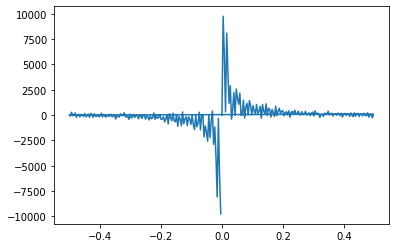

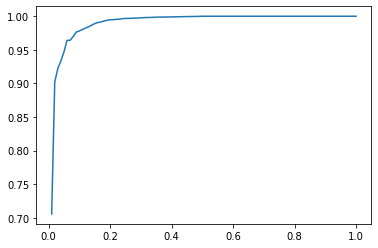

In [52]:
import matplotlib.pyplot as plt
fft_data , fre = historical.fft_analyse()

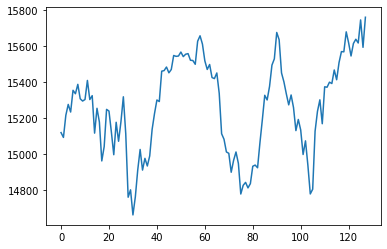

In [23]:
plt.plot(historical.train_data[0:128])

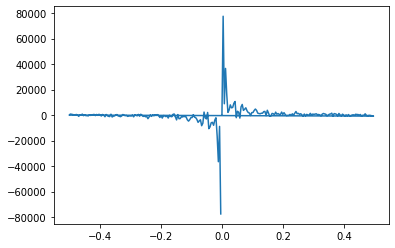

In [24]:
da = historical.train_data[0:256]
ff = np.fft.fft(da,axis=0)
freq = np.fft.fftfreq(da.shape[-1])
plt.plot(freq, ff.imag)

In [25]:
k = np.array([(da[i] + da[i+1] + da[i+2] + da[i+3])/4 for i in range(256 -4)])

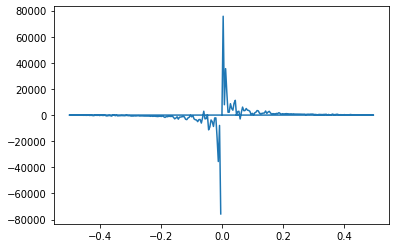

In [26]:
ff = np.fft.fft(k,axis=0)
freq = np.fft.fftfreq(k.shape[-1])
plt.plot(freq, ff.imag)

In [ ]:
historical.K_fold_purged(10,2,10,0)
x_train,y_train,x_val,y_val = historical.split_data(4,True,True)
ep = [10 , 20]
l_size = [10 , 20]
lr = [0.002]
historical.k_fold_LSTM(x_train,y_train,x_val,y_val,11,ep,l_size,lr)

In [ ]:
x_train,y_train,x_val,y_val = historical.split_data(4,True,True)

In [ ]:
ep = [10 , 20]
l_size = [10 , 20]
lr = [0.002]
historical.k_fold_LSTM(x_train,y_train,x_val,y_val,11,ep,l_size,lr)

epoch :  10, layer_size : 10 , lr : 0.002000
epoch :  10, layer_size : 20 , lr : 0.002000
epoch :  20, layer_size : 10 , lr : 0.002000
epoch :  20, layer_size : 20 , lr : 0.002000


(10, 10, 0.002)

In [43]:

historical.prepar_trian_test_with_smothing(step_size=4,deep=True , one_d=True)

Epoch 1/10
60/60 [==============================] - 1s 5ms/step - loss: 0.4678 - accuracy: 0.8511
Epoch 2/10
60/60 [==============================] - 0s 5ms/step - loss: 0.4278 - accuracy: 0.8564
Epoch 3/10
60/60 [==============================] - 0s 4ms/step - loss: 0.4254 - accuracy: 0.8564
Epoch 4/10
60/60 [==============================] - 0s 4ms/step - loss: 0.4242 - accuracy: 0.8564
Epoch 5/10
60/60 [==============================] - 0s 4ms/step - loss: 0.4306 - accuracy: 0.8564
Epoch 6/10
60/60 [==============================] - 0s 4ms/step - loss: 0.4215 - accuracy: 0.8564
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.4290 - accuracy: 0.8564
Epoch 8/10
60/60 [==============================] - 0s 5ms/step - loss: 0.4283 - accuracy: 0.8564
Epoch 9/10
60/60 [==============================] - 0s 5ms/step - loss: 0.4210 - accuracy: 0.8564
Epoch 10/10
60/60 [==============================] - 0s 4ms/step - loss: 0.4262 - accuracy: 0.8564
Accuracy:0.758256
P

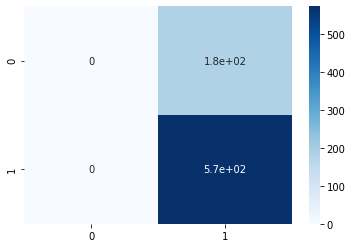

In [44]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=4,deep=True , one_d=True)
historical.evaluat_LSTM(10,10,11,0.002)

In [17]:
dfs = pd.read_excel("000001data.xlsx")

In [18]:
dfs

,DATE,openingprice,highestprice,lowestprice,closingprice,volume,amounts
0,1990-12-19,96.05,99.98,95.79,99.98,1260,494311
1,1990-12-20,104.30,104.39,99.98,104.39,197,84992
2,1990-12-21,109.07,109.13,103.73,109.13,28,16096
3,1990-12-24,113.57,114.55,109.13,114.55,32,31063
4,1990-12-25,120.09,120.25,114.55,120.25,15,6510
...,...,...,...,...,...,...,...
6851,2018-12-24,2506.74,2529.44,2500.44,2527.01,97339856,85760933888
6852,2018-12-25,2503.95,2513.96,2462.84,2504.82,140670560,114766012416
6853,2018-12-26,2501.12,2513.83,2492.08,2498.29,108799632,93989535744
6854,2018-12-27,2527.72,2532.00,2483.09,2483.09,135406848,112479764480


In [21]:
closing_price= dfs['closingprice']
label=labeling(dfs['closingprice'],0.15)   
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfs['DATE'][10:3000], y=dfs['closingprice'][10:3000]))
fig.show()
fig = go.Figure([go.Scatter(x=dfs['DATE'][10:3000], y=label[10:3000])])
fig.show()

In [83]:
historical = Train_data(closing_price,label,train_index_start=10,train_index_end=3010,test_index_end=6000)

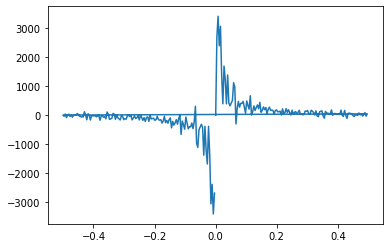

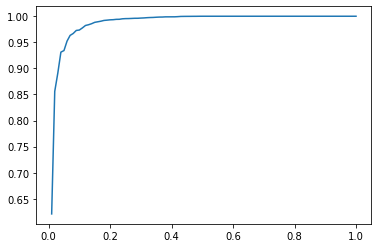

In [29]:
h,d = historical.fft_analyse()

In [ ]:
historical.K_fold_purged(8,2,10,0)
x_train,y_train,x_val,y_val = historical.split_data(4,True,True)
ep = [10 , 20]
l_size = [10 , 20]
lr = [0.002]
historical.k_fold_LSTM(x_train,y_train,x_val,y_val,11,ep,l_size,lr)

In [84]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=1,deep=True , one_d=True)
#historical.evaluat_LSTM(60,20,22,0.002)

Epoch 1/10
187/187 [==============================] - 2s 8ms/step - loss: 0.6751 - accuracy: 0.5913 - val_loss: 0.6578 - val_accuracy: 0.5685
Epoch 2/10
187/187 [==============================] - 1s 8ms/step - loss: 0.6058 - accuracy: 0.7077 - val_loss: 0.6003 - val_accuracy: 0.6919
Epoch 3/10
187/187 [==============================] - 1s 7ms/step - loss: 0.5830 - accuracy: 0.7090 - val_loss: 0.5985 - val_accuracy: 0.6899
Epoch 4/10
187/187 [==============================] - 1s 7ms/step - loss: 0.5724 - accuracy: 0.7214 - val_loss: 0.6199 - val_accuracy: 0.6644
Epoch 5/10
187/187 [==============================] - 1s 7ms/step - loss: 0.5752 - accuracy: 0.7151 - val_loss: 0.6010 - val_accuracy: 0.6752
Epoch 6/10
187/187 [==============================] - 1s 8ms/step - loss: 0.5711 - accuracy: 0.7184 - val_loss: 0.5899 - val_accuracy: 0.6839
Epoch 7/10
187/187 [==============================] - 1s 6ms/step - loss: 0.5612 - accuracy: 0.7181 - val_loss: 0.5940 - val_accuracy: 0.6802
Epoch 

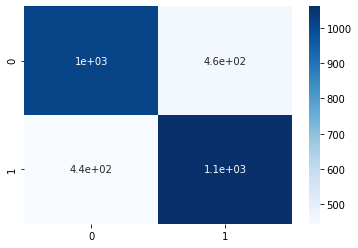

In [85]:
historical.evaluat_GRU(10,10,11,0.002,True,False)

Epoch 1/10
187/187 [==============================] - 3s 8ms/step - loss: 0.6879 - accuracy: 0.5475 - val_loss: 0.6720 - val_accuracy: 0.5836
Epoch 2/10
187/187 [==============================] - 1s 6ms/step - loss: 0.6115 - accuracy: 0.6863 - val_loss: 0.6050 - val_accuracy: 0.6919
Epoch 3/10
187/187 [==============================] - 1s 6ms/step - loss: 0.5948 - accuracy: 0.7067 - val_loss: 0.6389 - val_accuracy: 0.6430
Epoch 4/10
187/187 [==============================] - 1s 6ms/step - loss: 0.5882 - accuracy: 0.7084 - val_loss: 0.6312 - val_accuracy: 0.6372
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.5855 - accuracy: 0.7080 - val_loss: 0.5910 - val_accuracy: 0.6973
Epoch 6/10
187/187 [==============================] - 1s 7ms/step - loss: 0.5783 - accuracy: 0.7157 - val_loss: 0.5899 - val_accuracy: 0.6953
Epoch 7/10
187/187 [==============================] - 1s 6ms/step - loss: 0.5813 - accuracy: 0.7197 - val_loss: 0.6019 - val_accuracy: 0.6829
Epoch 

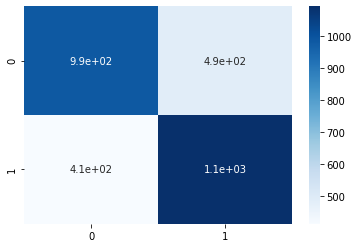

In [86]:
historical.evaluat_LSTM(10,10,11,0.002,True,False)

[0]	validation_0-auc:0.746877
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.746987
[2]	validation_0-auc:0.746751
[3]	validation_0-auc:0.748336
[4]	validation_0-auc:0.749532
[5]	validation_0-auc:0.749942
[6]	validation_0-auc:0.760478
[7]	validation_0-auc:0.763473
[8]	validation_0-auc:0.765167
[9]	validation_0-auc:0.763833
[10]	validation_0-auc:0.764174
[11]	validation_0-auc:0.763795
[12]	validation_0-auc:0.763232
[13]	validation_0-auc:0.759404
[14]	validation_0-auc:0.763086
[15]	validation_0-auc:0.763539
[16]	validation_0-auc:0.763643
[17]	validation_0-auc:0.763741
[18]	validation_0-auc:0.764044
[19]	validation_0-auc:0.764547
[20]	validation_0-auc:0.764123
[21]	validation_0-auc:0.764415
[22]	validation_0-auc:0.76482
[23]	validation_0-auc:0.76504
[24]	validation_0-auc:0.765133
[25]	validation_0-auc:0.764525
[26]	validation_0-auc:0.76479
[27]	validation_0-auc:0.764797
[28]	validation_0-auc:0.764576
[29]	validation_0-auc:0.764517
[30]	validation_0-a

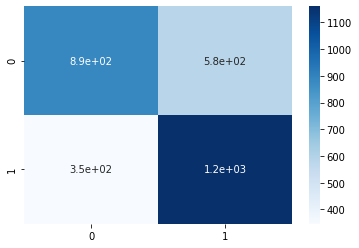

In [87]:
historical.evaluat_XGboost(50,False)

In [88]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=4,deep=True , one_d=True)
#historical.evaluat_LSTM(60,20,22,0.002)

Epoch 1/10
185/185 [==============================] - 2s 7ms/step - loss: 0.6832 - accuracy: 0.5749 - val_loss: 0.6664 - val_accuracy: 0.5277
Epoch 2/10
185/185 [==============================] - 1s 6ms/step - loss: 0.6394 - accuracy: 0.6760 - val_loss: 0.5965 - val_accuracy: 0.7472
Epoch 3/10
185/185 [==============================] - 1s 6ms/step - loss: 0.5891 - accuracy: 0.7146 - val_loss: 0.5647 - val_accuracy: 0.7414
Epoch 4/10
185/185 [==============================] - 1s 6ms/step - loss: 0.5605 - accuracy: 0.7335 - val_loss: 0.5433 - val_accuracy: 0.7139
Epoch 5/10
185/185 [==============================] - 1s 6ms/step - loss: 0.5379 - accuracy: 0.7460 - val_loss: 0.5251 - val_accuracy: 0.7336
Epoch 6/10
185/185 [==============================] - 1s 6ms/step - loss: 0.5269 - accuracy: 0.7508 - val_loss: 0.5371 - val_accuracy: 0.7187
Epoch 7/10
185/185 [==============================] - 1s 6ms/step - loss: 0.5183 - accuracy: 0.7602 - val_loss: 0.5176 - val_accuracy: 0.7377
Epoch 

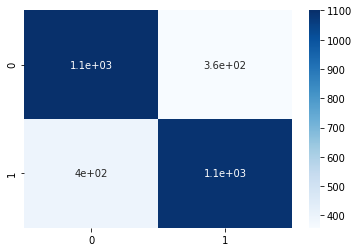

In [89]:
historical.evaluat_GRU(10,10,11,0.002,True,True)

Epoch 1/10
185/185 [==============================] - 3s 9ms/step - loss: 0.6702 - accuracy: 0.5793 - val_loss: 0.5988 - val_accuracy: 0.7122
Epoch 2/10
185/185 [==============================] - 2s 8ms/step - loss: 0.6384 - accuracy: 0.6540 - val_loss: 0.6047 - val_accuracy: 0.6705
Epoch 3/10
185/185 [==============================] - 1s 7ms/step - loss: 0.6321 - accuracy: 0.6760 - val_loss: 0.5683 - val_accuracy: 0.7262
Epoch 4/10
185/185 [==============================] - 1s 7ms/step - loss: 0.6230 - accuracy: 0.6764 - val_loss: 0.6286 - val_accuracy: 0.6026
Epoch 5/10
185/185 [==============================] - 1s 7ms/step - loss: 0.6114 - accuracy: 0.6885 - val_loss: 0.5497 - val_accuracy: 0.7309
Epoch 6/10
185/185 [==============================] - 2s 8ms/step - loss: 0.5947 - accuracy: 0.6994 - val_loss: 0.5765 - val_accuracy: 0.7194
Epoch 7/10
185/185 [==============================] - 1s 7ms/step - loss: 0.5823 - accuracy: 0.7169 - val_loss: 0.5364 - val_accuracy: 0.7316
Epoch 

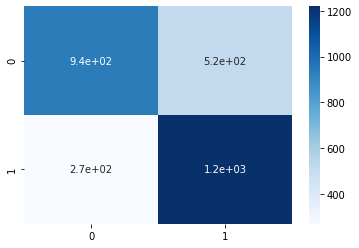

In [90]:
historical.evaluat_LSTM(10,10,11,0.002,True,True)

[0]	validation_0-auc:0.812339
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.825576
[2]	validation_0-auc:0.825452
[3]	validation_0-auc:0.825437
[4]	validation_0-auc:0.830094
[5]	validation_0-auc:0.830914
[6]	validation_0-auc:0.83039
[7]	validation_0-auc:0.829105
[8]	validation_0-auc:0.828316
[9]	validation_0-auc:0.830927
[10]	validation_0-auc:0.831121
[11]	validation_0-auc:0.831472
[12]	validation_0-auc:0.832094
[13]	validation_0-auc:0.830466
[14]	validation_0-auc:0.831738
[15]	validation_0-auc:0.830196
[16]	validation_0-auc:0.830662
[17]	validation_0-auc:0.83042
[18]	validation_0-auc:0.829674
[19]	validation_0-auc:0.830199
[20]	validation_0-auc:0.8313
[21]	validation_0-auc:0.830784
[22]	validation_0-auc:0.831153
[23]	validation_0-auc:0.830422
[24]	validation_0-auc:0.829635
[25]	validation_0-auc:0.829502
[26]	validation_0-auc:0.828521
[27]	validation_0-auc:0.827905
[28]	validation_0-auc:0.828807
[29]	validation_0-auc:0.829014
[30]	validation_0-au

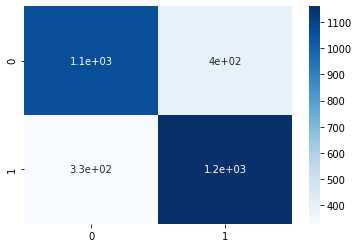

In [91]:
historical.evaluat_XGboost(50,True)

In [92]:
x= historical.tabel()

In [93]:
print(x)

+-------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|             Model             |      Accuracy      |     Precision      |       Recall       |      F1 score      |          MI         |
+-------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|              LSTM             | 0.6976510067114094 | 0.6913345983554712 | 0.7257636122177955 | 0.7081308713961776 | 0.08035498042456993 |
|              GRU              | 0.6959731543624161 | 0.6971090670170828 | 0.704515272244356  | 0.7007926023778072 | 0.07885497783290035 |
|            XGBoost            | 0.6875838926174497 | 0.664756446991404  | 0.7702523240371846 | 0.7136265764380191 | 0.07379436992702831 |
|   LSTM with 44 previous data  | 0.7332880895826264 | 0.7025936599423631 | 0.8186702484889188 | 0.7562034739454094 | 0.11662530509246563 |
|   GRU with 44 prev

In [ ]:

dfs = pd.read_csv("خودرو.csv")


In [ ]:
dfs

,id,date,time,max_price,min_price,last_price,last_deal_price,first_price,yesterday_price,value,volume,count,stock_id
0,305,2020-09-05,2020-09-05 13:49:41,3850,3630,3670,3840,3660,3820,8078379385040,2201302038,83416.0,6.588384e+16
1,893,2020-09-05,2020-09-05 13:59:21,3850,3630,3670,3840,3660,3820,8078379385040,2201302038,83416.0,6.588384e+16
2,1481,2020-09-05,2020-09-05 14:01:34,3850,3630,3670,3840,3660,3820,8078379385040,2201302038,83416.0,6.588384e+16
3,2193,2020-09-06,2020-09-06 09:03:00,0,0,3710,3710,0,3670,174710396210,47091751,3272.0,6.588384e+16
4,2641,2020-09-06,2020-09-06 09:04:00,0,0,3710,3710,0,3670,174710396210,47091751,3272.0,6.588384e+16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13197,8602728,2020-11-23,2020-11-23 09:14:00,4000,3800,3940,4000,3860,3880,945412355340,239897777,7587.0,6.588384e+16
13198,8603314,2020-11-23,2020-11-23 09:15:00,4040,3800,3950,4030,3860,3880,1074698918130,272019621,8440.0,6.588384e+16
13199,8603903,2020-11-23,2020-11-23 09:16:00,4040,3800,3950,4030,3860,3880,1074698918130,272019621,8440.0,6.588384e+16
13200,8604494,2020-11-23,2020-11-23 09:17:00,4050,3800,3960,4050,3860,3880,1176746626940,297262274,9485.0,6.588384e+16


In [ ]:
closing_price= dfs['last_price']
label=labeling(dfs['last_price'],0.05)   
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfs['date'][10:13000], y=dfs['last_price'][10:13000]))
fig.show()
fig = go.Figure([go.Scatter(x=dfs['date'][10:13000], y=label[10:13000])])
fig.show()

In [ ]:
historical = Train_data(closing_price,label,train_index_start=500,train_index_end=7000,test_index_end=12500)

In [ ]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=10,deep=True , one_d=True)
#historical.evaluat_LSTM(10,10,11,0.002)

[[3430 3430 3430 ... 3430 3410 3410]
 [3430 3430 3430 ... 3430 3410 3410]
 [3430 3430 3430 ... 3430 3410 3410]
 ...
 [3360 3360 3360 ... 3360 3360 3360]
 [3360 3360 3360 ... 3360 3360 3360]
 [3360 3360 3360 ... 3360 3360 3360]]
AAAA
[[3360 3360 3330 ... 3270 3270 3260]
 [3360 3360 3330 ... 3270 3270 3260]
 [3360 3360 3330 ... 3270 3260 3260]
 ...
 [3980 3980 3980 ... 3980 3980 3990]
 [3980 3980 3980 ... 3980 3980 3990]
 [3980 3980 3980 ... 3980 3980 3990]]
AAAA


Epoch 1/30
400/400 [==============================] - 3s 4ms/step - loss: 0.6819 - accuracy: 0.5591
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 0.6043 - accuracy: 0.6661
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5642 - accuracy: 0.7052
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5557 - accuracy: 0.7105
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5471 - accuracy: 0.7226
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5339 - accuracy: 0.7266
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5347 - accuracy: 0.7270
Epoch 8/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5340 - accuracy: 0.7256
Epoch 9/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5316 - accuracy: 0.7298
Epoch 10/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5276 - accuracy: 0.7362

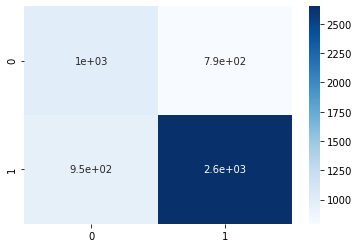

In [ ]:
historical.evaluat_GRU(30,10,11,0.002)

In [57]:
dfs = pd.read_csv("فملی.csv")

In [ ]:
dfs

,id,date,time,max_price,min_price,last_price,last_deal_price,first_price,yesterday_price,value,volume,count,stock_id
0,179,2020-09-05,2020-09-05 13:49:41,33530,32950,33510,33530,33530,31940,10458826757970,312090924,64652,35425587644337450
1,767,2020-09-05,2020-09-05 13:59:21,33530,32950,33510,33530,33530,31940,10458826757970,312090924,64652,35425587644337450
2,1355,2020-09-05,2020-09-05 14:01:34,33530,32950,33510,33530,33530,31940,10458826757970,312090924,64652,35425587644337450
3,2190,2020-09-06,2020-09-06 09:03:00,35180,35180,35180,35180,0,33510,451435353620,12832159,1552,35425587644337450
4,2638,2020-09-06,2020-09-06 09:04:00,35180,35180,35180,35180,0,33510,451435353620,12832159,1552,35425587644337450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47554,29779295,2021-05-17,2021-05-17 13:55:00,13050,12420,12700,12680,12600,13060,891445891020,70169908,11043,35425587644337450
47555,29779869,2021-05-17,2021-05-17 13:56:00,13050,12420,12700,12680,12600,13060,891445891020,70169908,11043,35425587644337450
47556,29780443,2021-05-17,2021-05-17 13:57:00,13050,12420,12700,12680,12600,13060,891445891020,70169908,11043,35425587644337450
47557,29781017,2021-05-17,2021-05-17 13:58:00,13050,12420,12700,12680,12600,13060,891445891020,70169908,11043,35425587644337450


In [58]:
closing_price= dfs['last_price']
label=labeling(dfs['last_price'],0.1)   
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfs['date'][10:43000], y=dfs['last_price'][10:43000]))
fig.show()
fig = go.Figure([go.Scatter(x=dfs['date'][10:43000], y=label[10:43000])])
fig.show()

In [90]:
historical = Train_data(closing_price,label,train_index_start=500,train_index_end=30000,test_index_end=40000)

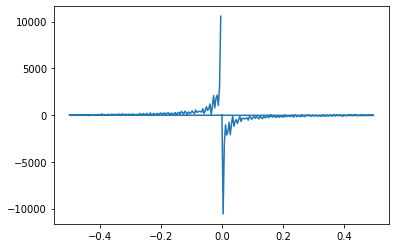

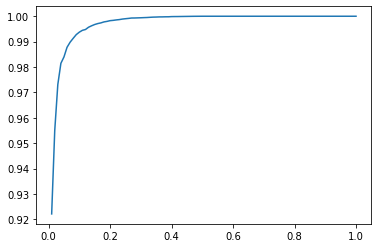

In [64]:
a,b= historical.fft_analyse()

In [60]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=4,deep=True , one_d=True)
#historical.evaluat_LSTM(10,10,11,0.002)

Epoch 1/10
1842/1842 [==============================] - 9s 4ms/step - loss: 0.6510 - accuracy: 0.6404
Epoch 2/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6293 - accuracy: 0.6541
Epoch 3/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6229 - accuracy: 0.6558
Epoch 4/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6184 - accuracy: 0.6547
Epoch 5/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6240 - accuracy: 0.6507
Epoch 6/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6238 - accuracy: 0.6530
Epoch 7/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6266 - accuracy: 0.6511
Epoch 8/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6201 - accuracy: 0.6558
Epoch 9/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6512 - accuracy: 0.6410
Epoch 10/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.650

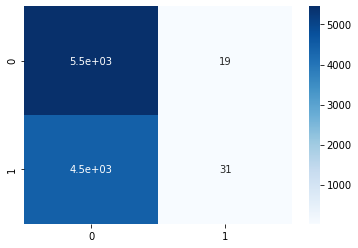

In [61]:
historical.evaluat_GRU(10,10,11,0.02)

In [91]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test_with_smothing(step_size=9,deep=True , one_d=True)
#historical.evaluat_LSTM(10,10,11,0.002)

In [93]:
historical.evaluat_GRU(10,20,11,0.002,True)

Epoch 1/50
1838/1838 [==============================] - 11s 6ms/step - loss: 0.6228 - accuracy: 0.6677 - val_loss: 0.6656 - val_accuracy: 0.5897
Epoch 2/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.6042 - accuracy: 0.6824 - val_loss: 0.6644 - val_accuracy: 0.5920
Epoch 3/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5990 - accuracy: 0.6858 - val_loss: 0.6483 - val_accuracy: 0.6192
Epoch 4/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5895 - accuracy: 0.6885 - val_loss: 0.6681 - val_accuracy: 0.6021
Epoch 5/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5790 - accuracy: 0.6947 - val_loss: 0.6458 - val_accuracy: 0.6497
Epoch 6/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5743 - accuracy: 0.6954 - val_loss: 0.6730 - val_accuracy: 0.5808
Epoch 7/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5710 - accuracy: 0.6993 - val_loss: 0.6511 - val_ac

KeyboardInterrupt: ignored

In [95]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=9,deep=True , one_d=True)
#historical.evaluat_LSTM(10,10,11,0.002)

Epoch 1/10
1838/1838 [==============================] - 13s 6ms/step - loss: 0.6203 - accuracy: 0.6683 - val_loss: 0.6618 - val_accuracy: 0.5861
Epoch 2/10
1838/1838 [==============================] - 10s 6ms/step - loss: 0.6056 - accuracy: 0.6798 - val_loss: 0.6731 - val_accuracy: 0.5813
Epoch 3/10
1838/1838 [==============================] - 11s 6ms/step - loss: 0.6026 - accuracy: 0.6817 - val_loss: 0.6481 - val_accuracy: 0.6177
Epoch 4/10
1838/1838 [==============================] - 10s 6ms/step - loss: 0.6008 - accuracy: 0.6827 - val_loss: 0.6712 - val_accuracy: 0.5802
Epoch 5/10
1838/1838 [==============================] - 10s 6ms/step - loss: 0.5982 - accuracy: 0.6853 - val_loss: 0.6567 - val_accuracy: 0.6073
Epoch 6/10
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5872 - accuracy: 0.6909 - val_loss: 0.6444 - val_accuracy: 0.6360
Epoch 7/10
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5748 - accuracy: 0.6985 - val_loss: 0.6677 - val_ac

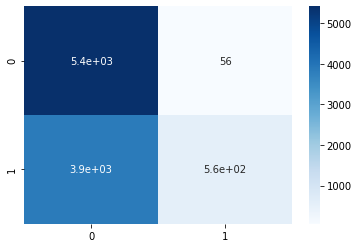

In [96]:
historical.evaluat_GRU(10,20,11,0.002,True)


In [20]:
dfs = pd.read_csv("HistoricalData_1627497050412.csv")
dfs = dfs[::-1].reset_index()

In [21]:
dfs

,index,Date,Close/Last,Volume,Open,High,Low
0,2556,07/28/2011,1300.67,--,1304.84,1316.32,1299.16
1,2555,07/29/2011,1292.28,--,1300.12,1304.16,1282.86
2,2554,08/01/2011,1286.94,--,1292.59,1307.38,1274.73
3,2553,08/02/2011,1254.05,--,1286.56,1286.56,1254.03
4,2552,08/03/2011,1260.34,--,1254.25,1261.20,1234.56
...,...,...,...,...,...,...,...
2552,4,07/21/2021,4358.69,--,4331.13,4359.70,4331.13
2553,3,07/22/2021,4367.48,--,4361.27,4369.87,4350.06
2554,2,07/23/2021,4411.79,--,4381.20,4415.18,4381.20
2555,1,07/26/2021,4422.30,--,4409.58,4422.73,4405.45


In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go

In [52]:
closing_price= dfs['Close/Last']
label=labeling(dfs['Close/Last'],0.15)   
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfs['Date'][10:2350], y=dfs['Close/Last'][10:2350]))
fig.show()
fig = go.Figure([go.Scatter(x=dfs['Date'][10:2350], y=label[10:2350])])
fig.show()

In [40]:
historical = Train_data(closing_price,label,train_index_start=10,train_index_end=1800,test_index_end=2350)

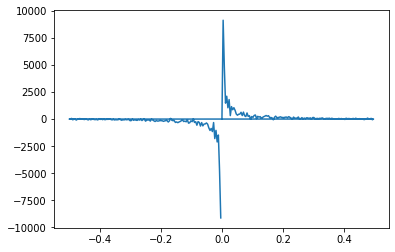

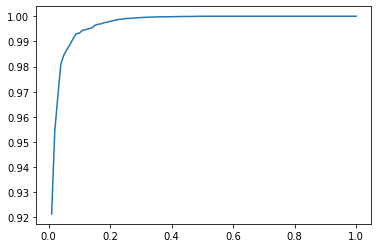

In [41]:
a,b = historical.fft_analyse()

In [ ]:
def  buy_and_hold(pric , pred , index):
  i = 0
  for i,p in enumerate(pred):
    if p == 1 :
      break
  value = pric[index + i]
  a = 0 
  a=value
  i +=1
  for j in range(len(pred) - i):
    if pred[i + j] == 1:
      value = pric[i+j + index]
  return value / a  


